# Introduction to LSTM

By: Guillaume De Gani

In [ ]:
import numpy
import matplotlib.pyplot as plt
import math
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This notebook is an introduction to the usage of LSTM and CNN on time series to make predictions. This technology has many applications. For example, the prediction of the stock market or, in this case, the consumption of a household.

In [ ]:
!ls drive/MyDrive/international-airline-passengers.csv

drive/MyDrive/international-airline-passengers.csv


Before we start working on a larger dataset it's iportant to have a basic understanding of how LSTM and Time Series work. To do so we use a fairly simple dataset based on the ammount of passengers for an airplane company.

In [ ]:

dataset = pandas.read_csv('drive/MyDrive/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset.head()



International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112                             
1                                                118                             
2                                                132                             
3                                                129                             
4                                                121

Here we plot the number of passengers over time to have an idea of what our data will look like.

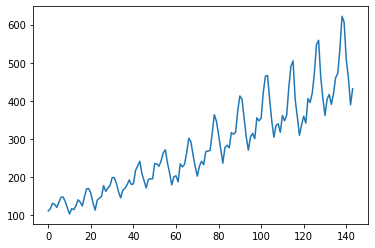

In [ ]:
plt.plot(dataset)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Librairies

In [ ]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Preparing the data

Before we can start making our prediction and training our model it is important to prepare the data to do we normalize it and remove ne Nan's to avoir any errors. After doing so we devide it into a training set and a validation set to check how accurate our prediction was.

In [ ]:
# normalize the dataset: since timeseries are of same nature, no point in normalizing with variance.
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets (since it is a time-series you cannot split it randomly)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [ ]:
# convert an array of values into a dataset matrix that contains the ammount of passagers at timestep t to timestep t-lookback 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Here we create a simple model just to have an idea of the diffrent parameters that are involved in LSTM's.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_164 (LSTM)             (None, 4)                 112       
                                                                 
 dense_123 (Dense)           (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25.14 RMSE
Test Score: 57.21 RMSE


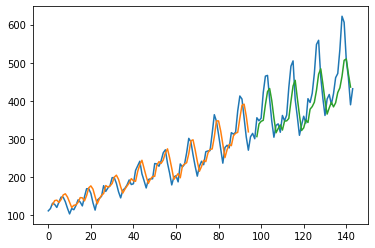

In [ ]:

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Bellow we create a function that creates a LSTM network with a specific value for the lookback

In [ ]:

def createLSTM(lookBack):
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, lookBack)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

LSTM_models = []
for i in range(5):
  LSTM_models.append(["Look back %i" % (i+1), createLSTM(i+1),i+1])

We create a list of models with various different values for the look back. By doing this we can later on iterate through the different models and compare them to chose the best value for the lookup.


In [ ]:
def showModels(LSTM_models,train,test):
  fig = plt.subplots(1,2, figsize=(15,30))  
  for i in range(len(LSTM_models)):
    look_back = LSTM_models[i][2]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    history = LSTM_models[i][1].fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    ax = plt.subplot(len(LSTM_models),2,2*i+1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    ax.plot(history.history['loss'])
    ax.set_title('Model Loss ' + LSTM_models[i][0] )
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['Training', 'Validation'])
    ax.grid()
    trainPredict = LSTM_models[i][1].predict(trainX)
    testPredict = LSTM_models[i][1].predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    ax = plt.subplot(len(LSTM_models),2,2*i+2)
    ax.plot(scaler.inverse_transform(dataset))
    ax.plot(trainPredictPlot)
    ax.plot(testPredictPlot)
    ax.set_title('Model prediction for ' + LSTM_models[i][0] )
    ax.legend(['Truth', 'Prediction in training','Prediction of test data'])
    ax.grid()

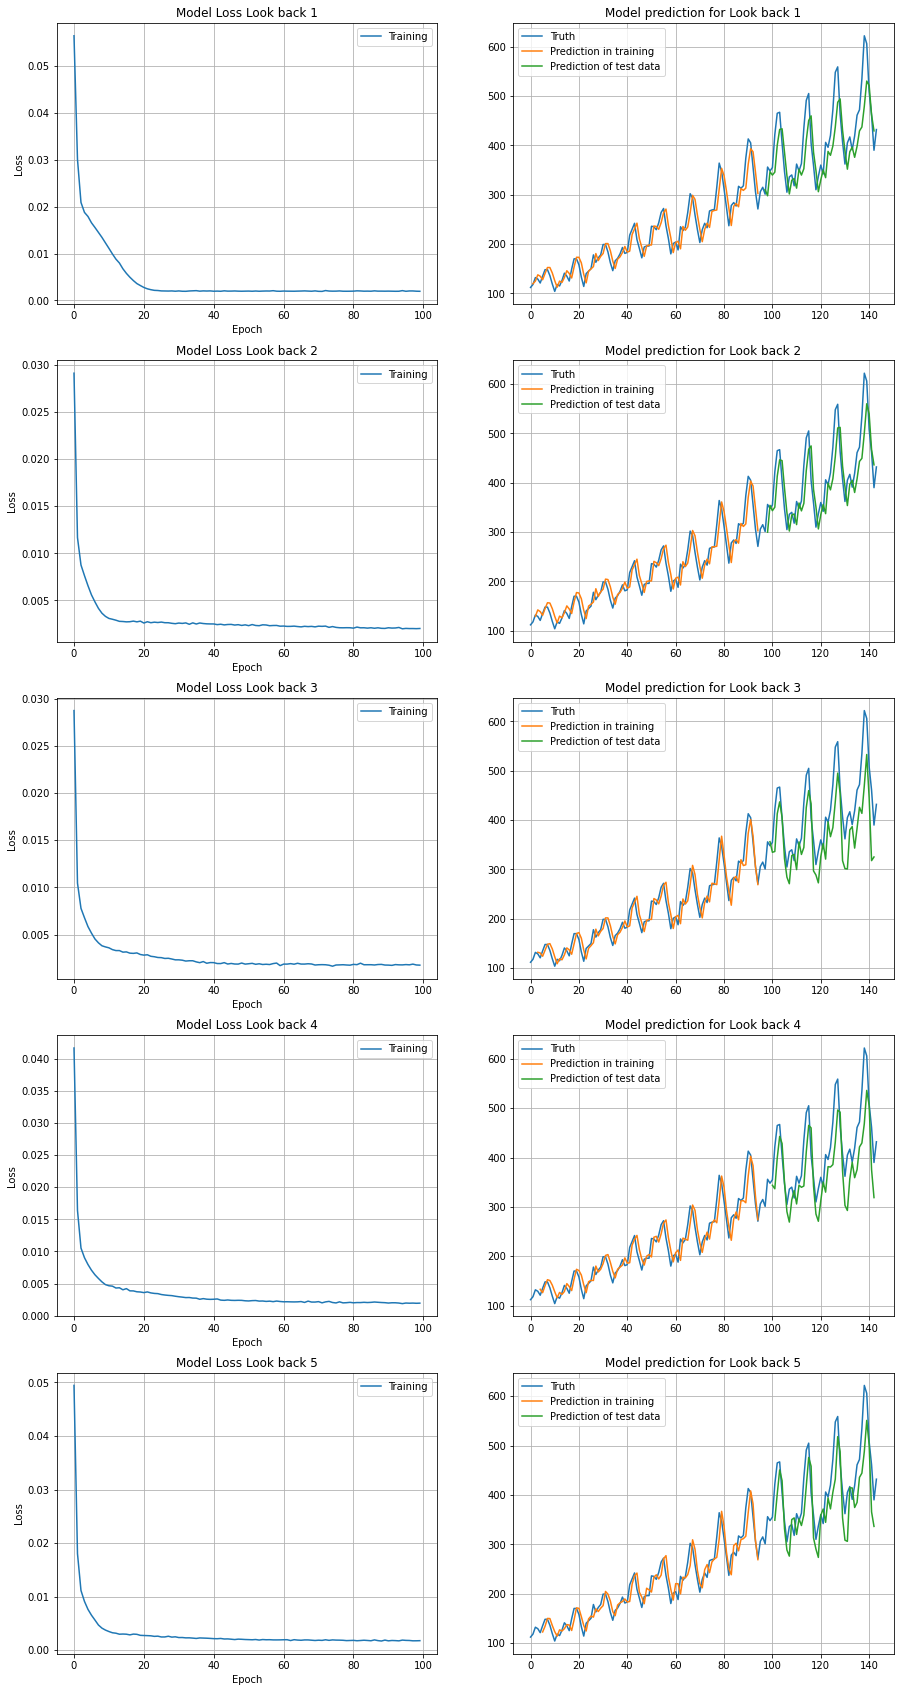

In [ ]:
#test the effect of changing the lookback value.
showModels(LSTM_models,train,test)

The graphs above are the results for the diffrent lookback values two things are noticable. First of all a higher lookback values isn't necesarlly corelated with an improvement in the prediction. Furthermore since the models looks further back a break appears in the prediction before the model can start make a which can be problematic. 

#Layers Comparaison
In this section we create a list of models with a various amount of LSTM layers to compare them

In [ ]:
LSTM_models_layers = []
look_back = 2
#Model With One Layers
model_1 = Sequential()
model_1.add(LSTM(4,input_shape=(1, look_back)))  
model_1.add(Dense(1))
model_1.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_layers.append(["One layer", model_1,look_back])
#Model With Two Layers
model_2 = Sequential()
model_2.add(LSTM(4, input_shape=(1, look_back),return_sequences=True))
model_2.add(LSTM(4,input_shape=(1, look_back)))  
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_layers.append(["Two layers", model_2,look_back])
#Model With Three Layers
model_3 = Sequential()
model_3.add(LSTM(4, input_shape=(1, look_back),return_sequences=True))
model_3.add(LSTM(4,input_shape=(1, look_back),return_sequences=True))
model_3.add(LSTM(4,input_shape=(1, look_back)))  
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_layers.append(["Three layers", model_3,look_back])
#Model With Four Layers
model_4 = Sequential()
model_4.add(LSTM(4, input_shape=(1, look_back),return_sequences=True))
model_4.add(LSTM(4,input_shape=(1, look_back),return_sequences=True))
model_4.add(LSTM(4,input_shape=(1, look_back),return_sequences=True))
model_4.add(LSTM(4,input_shape=(1, look_back)))  
model_4.add(Dense(1))
model_4.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_layers.append(["Four layer", model_4,look_back])

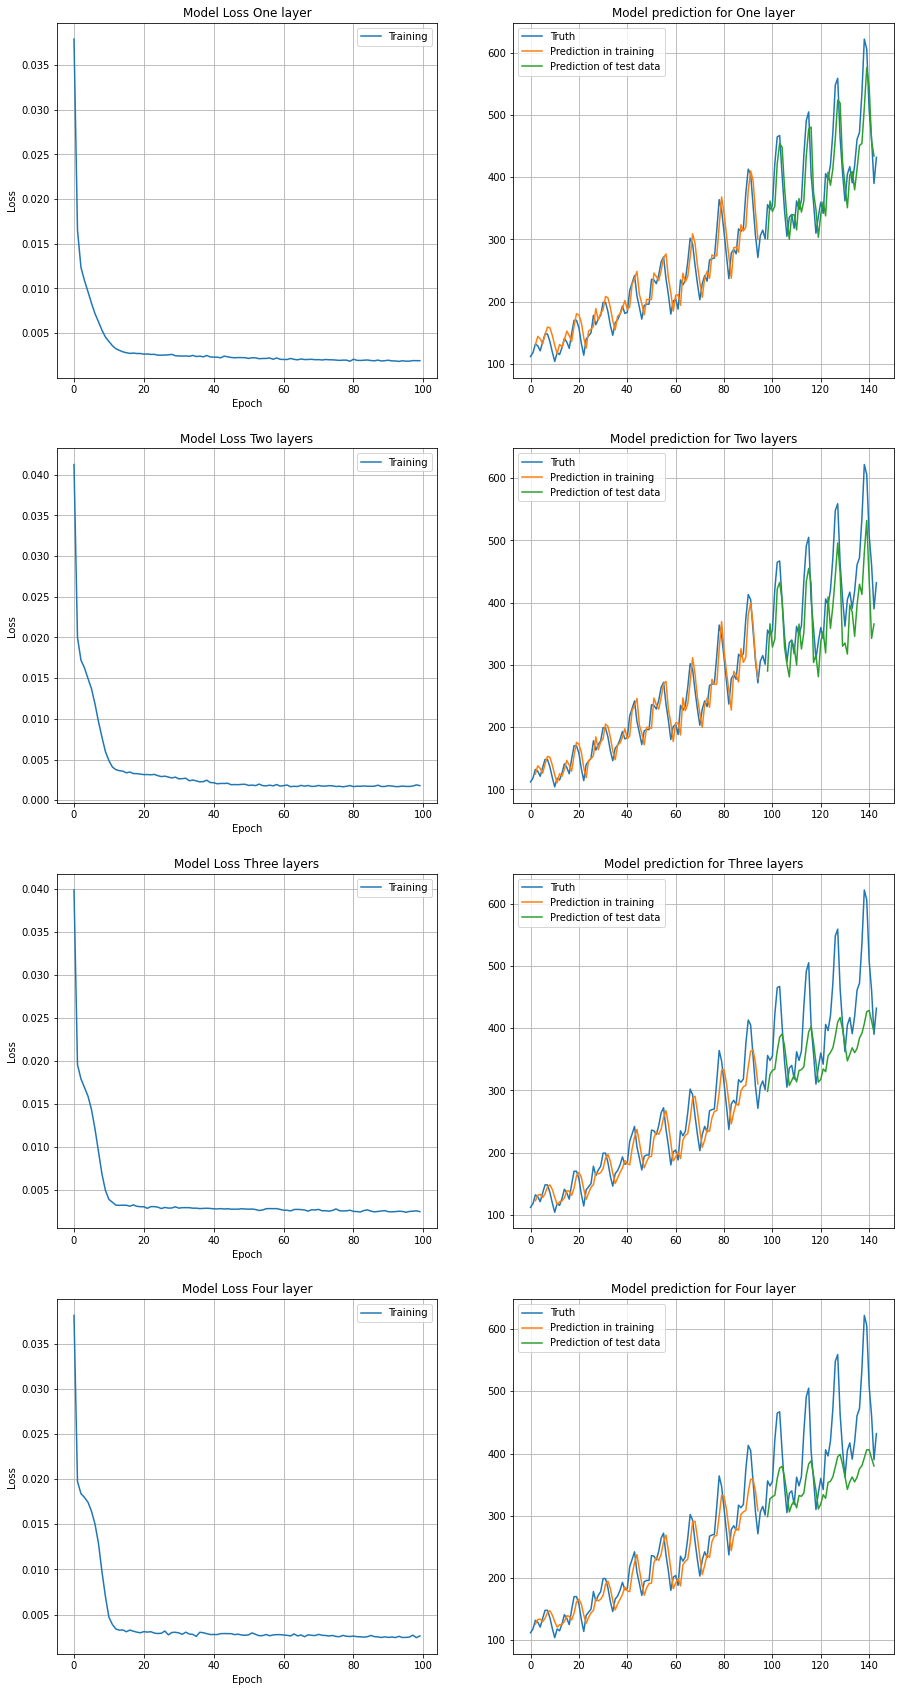

In [ ]:
showModels(LSTM_models_layers,train,test)

Increasing the ammount of LSTM layers makes the model more focused on the "pass" the consequence of this is that the models doesn't properly predict an increase in the ammount of passenger the more the time passes. This can be observed in the last graph where we use 4 LSTM layers and the model always underestimates the value compared to ground truth.

Train Score: 24.27 RMSE
Test Score: 50.71 RMSE


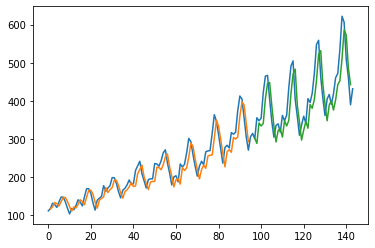

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#part of the code is not prefectly constient with the LSTM framework.
#Ideally we would want to treat it as a time sequence
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
#Do the results change?
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

The results are fairly similar to the one we got above however this structure will be usefulll when we try to train the CNN in the following part of the project.

In [ ]:
#Could we tranform the data by removing the tendence (result of a linear model between x and y) 
#from the targets and obtain better results?
#Going deeper, you can check the timedistributed keras tutorial:
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

In [ ]:
dataset = pandas.read_csv('drive/MyDrive/Work/3A/MAL/MSA/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [ ]:
from numpy import nan
from numpy import isnan
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
def replaceMissingValues(values):
  for row in range(values.shape[0]):
   for col in range(values.shape[1]):
    if (isnan(values[row, col])):
      values[row, col] = values[row - (60*24), col]



To complete the Nan's we get the value at the same time but the day before. Note I tried averaging the two closes value however it's fairly common that the Nan's follow eachother. 

In [ ]:
replaceMissingValues(dataset.values)

#Preparing the data

Before testing our models I decided to reduce the size of the data to do so it is possible to merge the data day by day by summing the values of each day. This reduces the size of the data by a large amount without losing to much information regarding the evolution of electricity consumption over the years or months. 

In [ ]:
global_active = pd.DataFrame(dataset['Global_active_power'])
global_reactive = pd.DataFrame(dataset['Global_reactive_power'])
volatge = pd.DataFrame(dataset['Voltage'])
global_intensity = pd.DataFrame(dataset['Global_intensity'])
global_active_groups = global_active.resample('D')
data_global_active = global_active_groups.sum()
global_reactive_groups = global_reactive.resample('D')
data_global_reactive = global_reactive_groups.sum()
volatge_groups = volatge.resample('D')
data_volatge = volatge_groups.sum()
global_intensity_groups = global_intensity.resample('D')
data_global_intensity = global_intensity_groups.sum()
datas = [data_global_active,data_global_reactive,data_volatge,data_global_intensity]

Bellow we create a list of models with a varying amount of layers and lookback value. A notable think here is the larger lookback value since it's possible that lookin what happend the day before could be very helpful to make a prediction. 

In [ ]:
LSTM_models_testing = []
#Model One 
model_1 = Sequential()
model_1.add(LSTM(12,input_shape=(1, 8)))  
model_1.add(Dense(1))
model_1.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_testing.append(["Model 1 layer lookback 8", model_1,8])
#Model Two 
model_2 = Sequential()
model_2.add(LSTM(12, input_shape=(1, 8),return_sequences=True))
model_2.add(LSTM(12,input_shape=(1, 8)))  
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_testing.append(["Model 2 layers lookback 8", model_2,8])
#Model Three 
model_3 = Sequential()
model_3.add(LSTM(12,input_shape=(1, 16)))  
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_testing.append(["Model 1 layer lookback 16", model_3,16])
#Model Four
model_4 = Sequential()
model_4.add(LSTM(12, input_shape=(1, 16),return_sequences=True))
model_4.add(LSTM(12,input_shape=(1, 16)))  
model_4.add(Dense(1))
model_4.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_testing.append(["Model 2 layers lookback 16", model_4,16])
#Model Five 
model_5 = Sequential()
model_5.add(LSTM(12,input_shape=(1, 32)))  
model_5.add(Dense(1))
model_5.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_testing.append(["Model 1 layer lookback 32", model_5,32])
#Model Six
model_6 = Sequential()
model_6.add(LSTM(12, input_shape=(1, 32),return_sequences=True))
model_6.add(LSTM(12,input_shape=(1, 32)))  
model_6.add(Dense(1))
model_6.compile(loss='mean_squared_error', optimizer='adam')
LSTM_models_testing.append(["Model 2 layers lookback 32", model_6,32])

In [ ]:
list_of_train_test = []
adapted_datatets = []
#Function that creates the list of train and test data
def createDataList(list_of_data):
  for i in range(len(list_of_data)):  
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = list_of_data[i]
    dataset = scaler.fit_transform(data)
    adapted_datatets.append(dataset)
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(data_global_active),:]
    list_of_train_test.append([train,test])
createDataList(datas)

To evaluate the diffrent models and there efficiency at predicting the future we iterate threw the models and select the one with the smallest RMSE. This indecates that it was the best model from the list of models that was given.
It's important to understand that this method is fairly time consumming however finding the right strucutre for our data is usually donne by trial and error.

In [ ]:

def showBestModels(LSTM_models,listOfData):
  fig = plt.subplots(1,1, figsize=(110,30))
  for j in range(len(listOfData)):
    train = listOfData[j][0]
    test = listOfData[j][1]
    indexBestModel = -1
    minimalRmse = 99999999999999999999  
    for i in range(len(LSTM_models)):
      look_back = LSTM_models[i][2]
      trainX, trainY = create_dataset(train, look_back)
      testX, testY = create_dataset(test, look_back)
      trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
      testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
      history = LSTM_models[i][1].fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)
      trainPredict = LSTM_models[i][1].predict(trainX)
      testPredict = LSTM_models[i][1].predict(testX)
      # invert predictions
      trainPredict = scaler.inverse_transform(trainPredict)
      trainY = scaler.inverse_transform([trainY])
      testPredict = scaler.inverse_transform(testPredict)
      testY = scaler.inverse_transform([testY])
      testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
      if testScore < minimalRmse:
        minimalRmse = testScore
        indexBestModel = i
    look_back = LSTM_models[indexBestModel][2]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    trainPredict = LSTM_models[indexBestModel][1].predict(trainX)
    testPredict = LSTM_models[indexBestModel][1].predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(adapted_datatets[j])
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(adapted_datatets[j])
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(adapted_datatets[j])-1, :] = testPredict
    # plot baseline and predictions
    ax = plt.subplot(len(LSTM_models),2,2*j+1)
    ax.plot(scaler.inverse_transform(adapted_datatets[j]))
    ax.plot(trainPredictPlot)
    ax.plot(testPredictPlot)
    ax.set_title('Model prediction for ' + LSTM_models[indexBestModel][0] )
    ax.legend(['Truth', 'Prediction in training','Prediction of test data'])
    ax.grid()
      

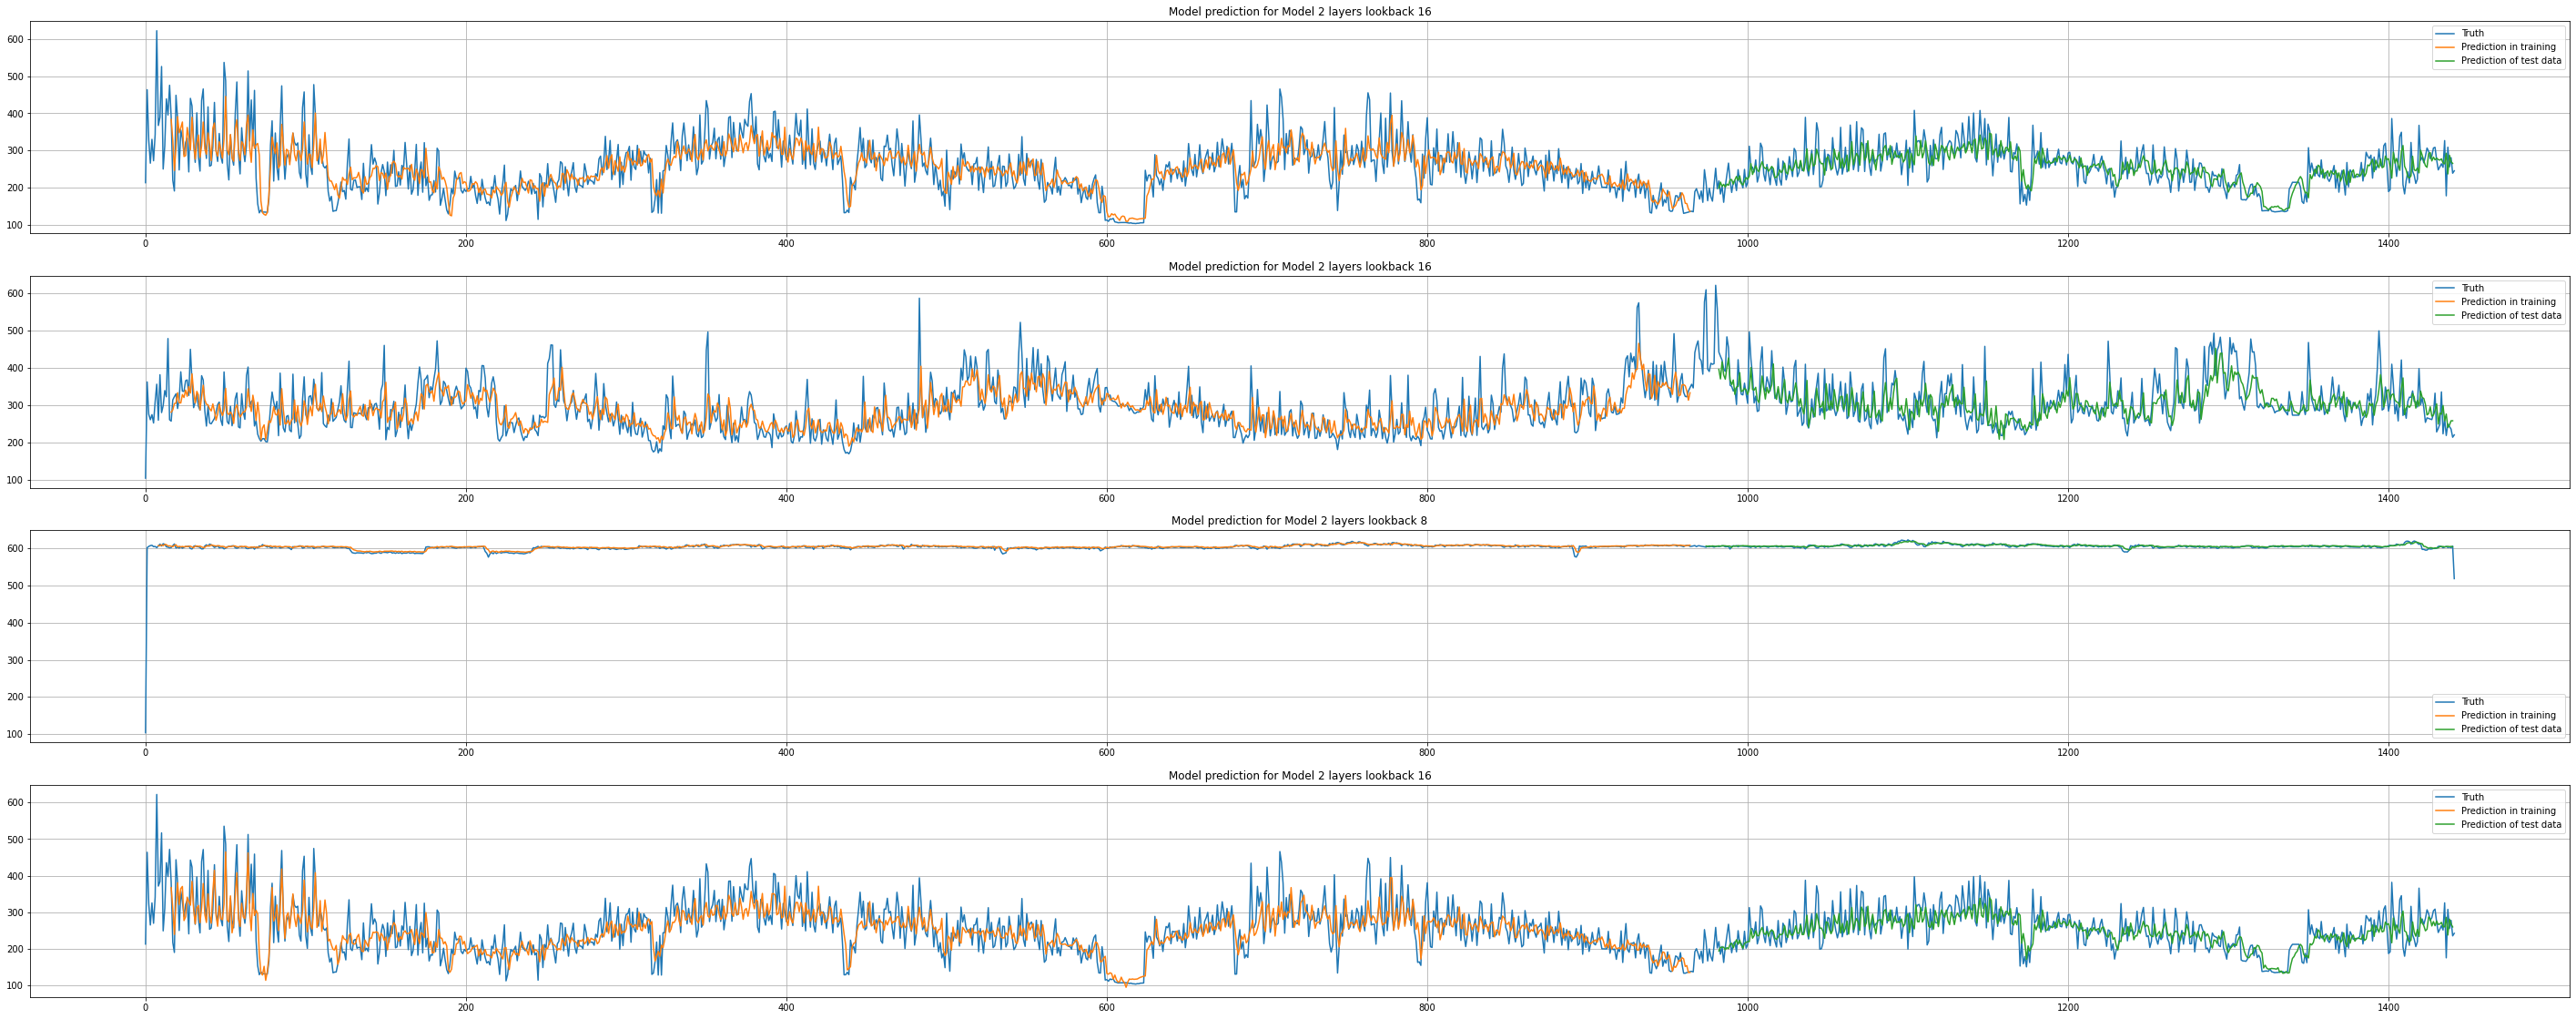

In [ ]:
showBestModels(LSTM_models_testing,list_of_train_test)

The results are interesting since the diffrent dataset we study require a diffrent LSTM structure. Furthermore the results are fairly promisssing since they are fairly similar to the ground truth a seen in the test data prediction. The third graph is interesting since the model can fairly accuratly predict the drops in intensity.

#1D-CNN
The idea here is to use a window that will be compressed to a lower dimmension using a 1-D convolution and at the end the model will try to give a prediction. The prediction is is done on the `n_steps` previous points if available. 



In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers import Dropout
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from numpy import array
n_steps = 20
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
trainX, trainY = split_sequence(list_of_train_test[0][0], n_steps)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX, testY = split_sequence(list_of_train_test[0][1], n_steps)
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
#Creation of the 1 d CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_steps,1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(50, activation='linear'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)


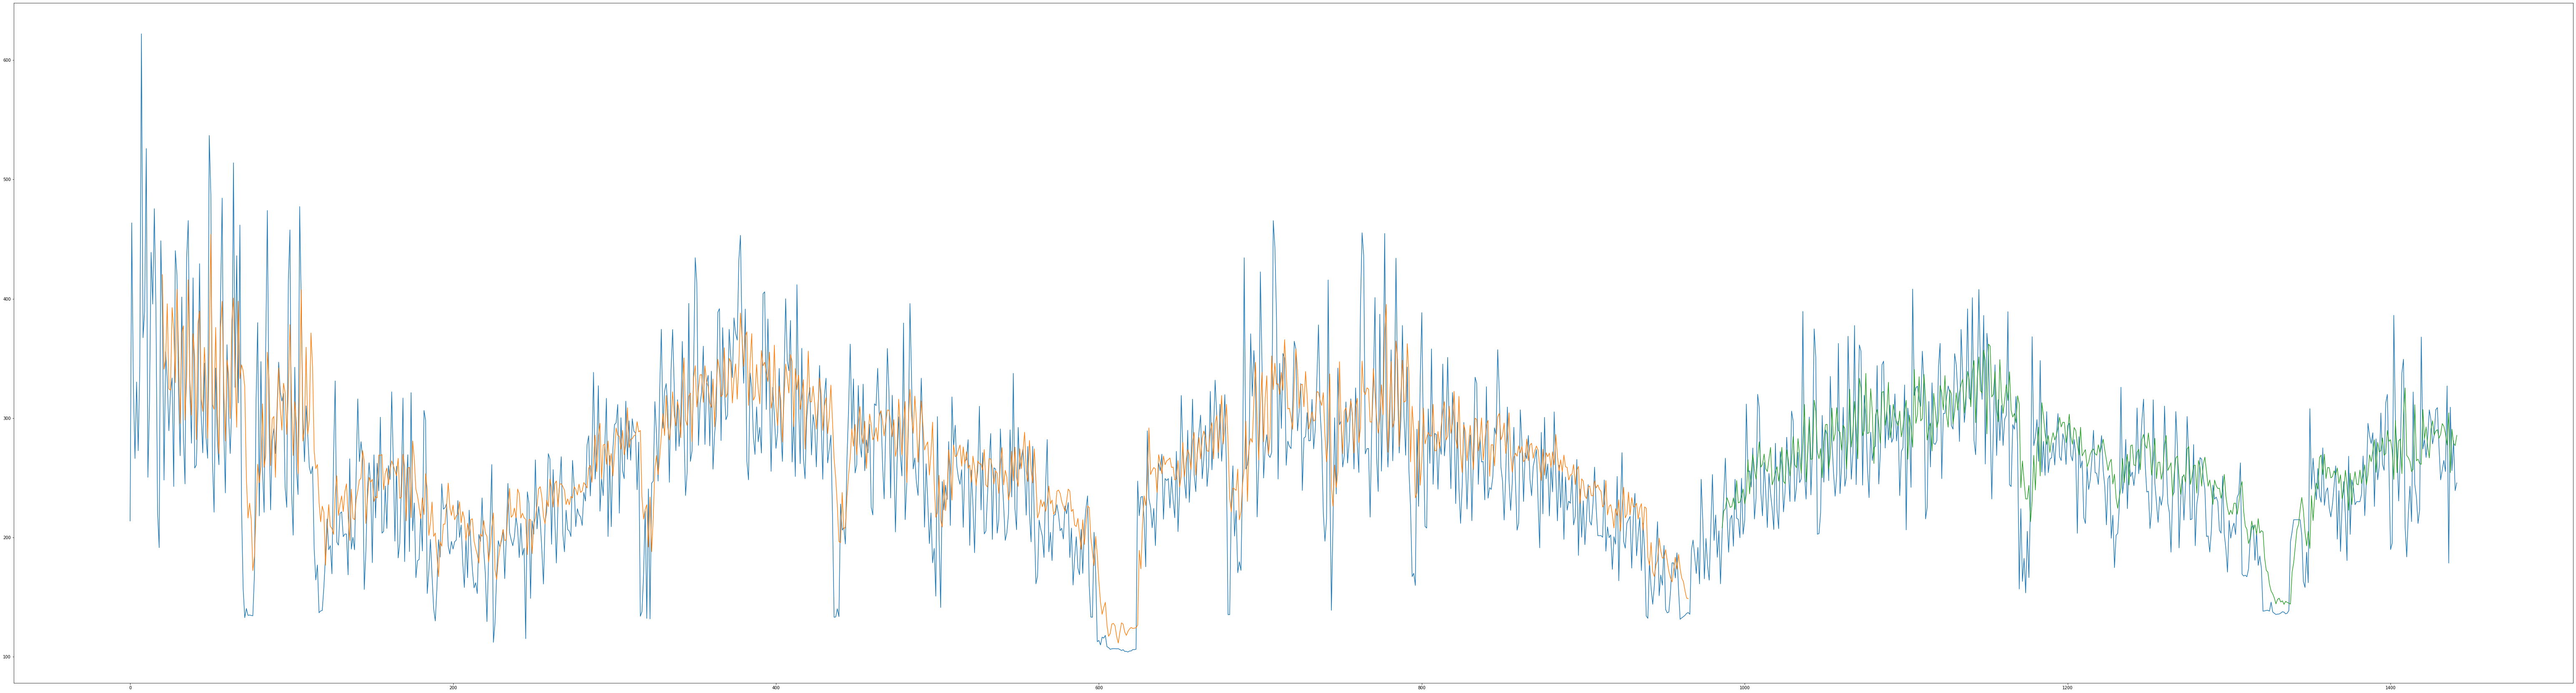

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([np.array(trainY).ravel()])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([np.array(testY).ravel()])

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(adapted_datatets[0])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[n_steps:len(trainPredict)+n_steps, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(adapted_datatets[0])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(n_steps*2):len(adapted_datatets[0]), :] = testPredict
# plot baseline and predictions
f = plt.figure(figsize=(110,30))
plt.plot(scaler.inverse_transform(adapted_datatets[0]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

The results show that the prediction is not very accurate on a predction per prediction basis. However the model i usually able to predict the general tendancy of the data we are studying. Note it would have been possible to use more features to make thre prediction for example watch the the `Global_active_power` and the `Intensity` to predict the next value. The LSTM seems to be better since the prediction is closer to the ground truth.